In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as m
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Specify the path to your CSV file
# data_path = 'E:\\THESIS\\MS\\Data Collection - Preparation\\rg1-revised-cleaned-with-popcount-and-neighbors.csv'
# data_path = '/content/drive/MyDrive/MS thesis/HFCAI/BARMM/barmm_cleaned_sum.csv'
data_path = '/content/drive/MyDrive/MS thesis/HFCAI/BARMM/barmm-cleaned.csv'
df = pd.read_csv(data_path)
df.head(2)

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,Distance_to_Nearest_RHU_km,drought_value,flood_probability_value,rain intensity_value,children_u,elderly_60,women_repr,womenmean,youthmean,all_popula
0,2708537,bg-39207,Likud Bakkao,Turtle Islands,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,NaN,...,216.535563,0.587594,0.003302,0.819815,0.861518,0.429093,3.033754,4.887959,2.387869,NaN
1,2720913,bg-39123,Sikub,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,NaN,...,248.670612,0.542750,0.636563,0.759982,0.205077,0.126357,0.561532,1.040952,0.436198,0.793358


# HCFAI calculations

In [40]:
def HCI_calc(total_ai, total_gi, total_hi, total_ji, total_ki, total_mi,
              distance, road_bi, POI_ci, landCov_di, hazard1_ei, hazard2_ei, hazard3_ei, rhus_fi):

    total_vulnerable = total_gi + total_hi + total_ji + total_ki + total_mi
    total_pop = total_ai
    population_to_be_served = total_vulnerable + np.maximum(0, total_pop - total_vulnerable)

    # Calculate y for the entire Series without using if condition
    y = np.where(population_to_be_served == 0, 0, 20000 / ((population_to_be_served) * (distance + rhus_fi)))
    mc = np.tanh(y)

    w_bi = 0.3 # roads
    w_ci = 0.2 # POIs
    w_di = 0.5 # land cov

    b = (POI_ci * w_ci) + (road_bi * w_bi) + (landCov_di * w_di)

    # Normalize each factor
    rain_intensity_normalized = (hazard1_ei - hazard1_ei.min()) / (hazard1_ei.max() - hazard1_ei.min())
    flood_probability_normalized = (hazard2_ei - hazard2_ei.min()) / (hazard2_ei.max() - hazard2_ei.min())
    drought_mean_normalized = (hazard3_ei - hazard3_ei.min()) / (hazard3_ei.max() - hazard3_ei.min())
    w_rain = 0.4
    w_flood = 0.3
    w_drought = 0.3
    c = (w_rain * rain_intensity_normalized) + (w_flood * flood_probability_normalized) + (w_drought * drought_mean_normalized)

    f = b - c
    f = np.tanh(f)

    hci = mc * f
    hcfai = (1 + np.tanh(hci / 2)) / 2  # Sigmoid function

    return hcfai

In [41]:
df.columns

Index(['ID', 'bg_id', 'barangay_name', 'city_name', 'province_name',
       'region_name', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'buildability_landcov', 'Nearest_RHU', 'Distance_to_Nearest_RHU_km',
       'drought_value', 'flood_probability_value', 'rain intensity_value',
       'children_u', 'elderly_60', 'women_repr', 'womenmean', 'youthmean',
       'all_popula'],
      dtype='object')

In [42]:
df.columns
# Rename columns
column_mapping = {
    'youthmean': 'popden_you',
    'womenmean': 'popden_wom',
    'women_repr': 'popden_w_1',
    'elderly_60': 'popden_eld',
    'children_u': 'popden_chi',
    'all_popula': 'popden_all',
}

# dropcols = ['children_u', 'elderly_60', 'women_repr', 'womenmean', 'youthmean',
      #  'all_popula']
# df = df.drop(columns=dropcols)

df = df.rename(columns=column_mapping)
df.loc[df['RHU_Presence'] == 1, 'Distance_to_Nearest_RHU_km'] = 0
df[df['RHU_Presence'] == 1]

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,Distance_to_Nearest_RHU_km,drought_value,flood_probability_value,rain intensity_value,popden_chi,popden_eld,popden_w_1,popden_wom,popden_you,popden_all
222,2899307,bg-39211,Darussalam,Languyan,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,0.0,...,0.0,0.782888,0.806954,0.649332,0.075016,0.042772,0.215178,0.444175,0.163193,0.463344
302,2976681,bg-38925,Tong-tong,Siasi,Sulu,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.716486,0.757822,0.645443,1.794643,0.569586,7.150182,13.265952,5.708822,23.110114
310,2979444,bg-38885,Poblacion (Campo Baro),Siasi,Sulu,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,0.0,...,0.0,0.740278,0.666753,0.645262,37.666691,29.410978,159.954439,263.150852,108.872215,6.970232
396,2998767,bg-38739,Poblacion (Maimbung),Maimbung,Sulu,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.881611,0.739322,0.621261,1.182688,0.137544,2.022507,3.948870,1.397269,5.186602
423,3113434,bg-36954,Bohe-Pahuh,Ungkaya Pukan,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,1.0,...,0.0,0.793008,0.301379,0.673888,2.488529,0.539735,4.267441,8.667603,3.003932,0.452582
427,3114806,bg-36812,Boheyawas,City of Lamitan,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,1.0,...,0.0,0.849306,0.840884,0.693443,0.570855,0.307090,1.085202,2.184940,0.847216,0.468286
429,3114817,bg-36893,Sapah Bulak,Sumisip,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.754519,0.293768,0.674711,0.182279,0.027287,0.259229,0.605232,0.180642,0.789469
445,3118953,bg-36815,Maganda,City of Lamitan,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.840049,0.850477,0.701609,0.850068,0.364093,1.831475,3.589907,1.361843,10.568023
448,3118964,bg-36902,Baguindan,Tipo-Tipo,Basilan,Autonomous Region In Muslim Mindanao (ARMM),1,0,1,0.0,...,0.0,0.708655,0.273977,0.682473,2.188476,0.351202,4.076798,7.910613,3.378070,0.860232
483,3324791,bg-37220,Pindolonan,Ganassi,Lanao del Sur,Autonomous Region In Muslim Mindanao (ARMM),1,0,0,0.0,...,0.0,0.567100,0.110306,0.966702,0.384814,0.053758,0.730277,1.459956,0.578582,1.226430


In [43]:
# Get column names with NaNs using list comprehension
columns_with_nan = [col for col in df.columns if df[col].isna().any()]

# Print the column names
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: ['buildability_landcov', 'rain intensity_value', 'popden_chi', 'popden_eld', 'popden_w_1', 'popden_wom', 'popden_you', 'popden_all']


In [44]:
# Impute NaNs with 0, considering data type safety
for col in columns_with_nan:
    # Check data type before imputing (avoid unintended conversions)
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(0)  # Impute with 0 for numeric columns
    else:
        df[col] = df[col].fillna('NA')  # Impute with 'NA' for non-numeric columns
df

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,Distance_to_Nearest_RHU_km,drought_value,flood_probability_value,rain intensity_value,popden_chi,popden_eld,popden_w_1,popden_wom,popden_you,popden_all
0,2708537,bg-39207,Likud Bakkao,Turtle Islands,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,216.535563,0.587594,0.003302,0.819815,0.861518,0.429093,3.033754,4.887959,2.387869,0.000000
1,2720913,bg-39123,Sikub,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,248.670612,0.542750,0.636563,0.759982,0.205077,0.126357,0.561532,1.040952,0.436198,0.793358
2,2720914,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,248.107823,0.542142,0.637052,0.760291,0.717960,0.229747,0.896653,1.978380,0.494595,1.275429
3,2722294,bg-39118,Kompang,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,247.858424,0.539215,0.534102,0.757254,0.120270,0.109261,0.506118,0.885944,0.426542,0.316529
4,2722295,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,247.352915,0.542142,0.637052,0.760291,0.643299,0.214702,0.828093,1.811541,0.474045,0.742785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,3410548,bg-38183,Mangadeg,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,1,1,0.0,...,1.646340,1.307077,0.376025,0.737530,0.099621,0.013089,0.160562,0.323857,0.127882,0.722693
748,3411930,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),1,1,0,0.0,...,0.000000,1.301960,0.374058,0.739402,0.204595,0.012834,0.210992,0.426037,0.154978,0.664719
749,3411931,bg-38185,Puya,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.646419,1.285973,0.385058,0.734010,0.129855,0.009759,0.176954,0.368603,0.140294,0.601352
750,3413311,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.646315,1.301960,0.374058,0.739402,0.151020,0.019945,0.354779,0.631366,0.337221,0.526848


In [45]:
columns_with_nan = [col for col in df.columns if df[col].isna().any()]
print("Columns with NaN values:", columns_with_nan)

Columns with NaN values: []


In [46]:
df.columns

Index(['ID', 'bg_id', 'barangay_name', 'city_name', 'province_name',
       'region_name', 'RHU_Presence', 'Road_Presence', 'POI_Presence',
       'buildability_landcov', 'Nearest_RHU', 'Distance_to_Nearest_RHU_km',
       'drought_value', 'flood_probability_value', 'rain intensity_value',
       'popden_chi', 'popden_eld', 'popden_w_1', 'popden_wom', 'popden_you',
       'popden_all'],
      dtype='object')

In [47]:
# VARIABLES
# population vulnerable
popall = df["popden_all"]
children = df["popden_chi"]
elderly = df["popden_eld"]
women = df["popden_wom"]
women_reproductive = df["popden_w_1"]
youth = df["popden_you"]
distance = df["Distance_to_Nearest_RHU_km"]

flood = df["flood_probability_value"]
rain_intensity = df["rain intensity_value"]
drought = df["drought_value"]
roads = df["Road_Presence"]
rhus = df["RHU_Presence"]
pois = df["POI_Presence"]
buildability = df["buildability_landcov"]

In [48]:
df['HCFAI'] = HCI_calc(popall, children, elderly, women, women_reproductive, youth, distance,
    roads, pois, buildability, drought, rain_intensity, flood, rhus)

# Data exploration and visualization

In [49]:
nan_rows = df[df['HCFAI'].isna()]
nan_rows
df = df.dropna(subset=['HCFAI'])
df

,ID,bg_id,barangay_name,city_name,province_name,region_name,RHU_Presence,Road_Presence,POI_Presence,buildability_landcov,...,drought_value,flood_probability_value,rain intensity_value,popden_chi,popden_eld,popden_w_1,popden_wom,popden_you,popden_all,HCFAI
0,2708537,bg-39207,Likud Bakkao,Turtle Islands,Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.587594,0.003302,0.819815,0.861518,0.429093,3.033754,4.887959,2.387869,0.000000,0.440842
1,2720913,bg-39123,Sikub,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.542750,0.636563,0.759982,0.205077,0.126357,0.561532,1.040952,0.436198,0.793358,0.403804
2,2720914,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.542142,0.637052,0.760291,0.717960,0.229747,0.896653,1.978380,0.494595,1.275429,0.403809
3,2722294,bg-39118,Kompang,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.539215,0.534102,0.757254,0.120270,0.109261,0.506118,0.885944,0.426542,0.316529,0.411100
4,2722295,bg-39127,Erok-erok,Mapun (Cagayan De Tawi-Tawi),Tawi-Tawi,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,0.542142,0.637052,0.760291,0.643299,0.214702,0.828093,1.811541,0.474045,0.742785,0.403809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747,3410548,bg-38183,Mangadeg,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,1,1,0.0,...,1.307077,0.376025,0.737530,0.099621,0.013089,0.160562,0.323857,0.127882,0.722693,0.462566
748,3411930,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),1,1,0,0.0,...,1.301960,0.374058,0.739402,0.204595,0.012834,0.210992,0.426037,0.154978,0.664719,0.416949
749,3411931,bg-38185,Puya,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.285973,0.385058,0.734010,0.129855,0.009759,0.176954,0.368603,0.140294,0.601352,0.361776
750,3413311,bg-38181,Katil,Datu Paglas,Maguindanao,Autonomous Region In Muslim Mindanao (ARMM),0,0,0,0.0,...,1.301960,0.374058,0.739402,0.151020,0.019945,0.354779,0.631366,0.337221,0.526848,0.361038


In [50]:
print(max(list(df['HCFAI'].unique())))
# list(df['HCFAI'].unique())
print(min(list(df['HCFAI'].unique())))
# list(df['drought_value'])
# list(df['rain intensity_value'])
# list(df['flood_probability_value'])
for col in df.columns:
  print(col)

0.6355205205363005
0.34985193673407244
ID
bg_id
barangay_name
city_name
province_name
region_name
RHU_Presence
Road_Presence
POI_Presence
buildability_landcov
Nearest_RHU
Distance_to_Nearest_RHU_km
drought_value
flood_probability_value
rain intensity_value
popden_chi
popden_eld
popden_w_1
popden_wom
popden_you
popden_all
HCFAI


Dropped Rows that had HCFAI = nan

In [51]:
# mid_to_high = []
# for i in list(df['HCFAI']):
#     if i >= 0.53:
#         mid_to_high.append(i)

# filtered_original_df = df[df['HCFAI'].isin(mid_to_high)]
# filtered_original_df = df[df['RHU_Presence'] == 1]

# x = df['HCFAI'].notna() # removing nan values
# x = df[x]
x=df[['popden_all', 'popden_you', "popden_w_1",
                      "popden_wom", "popden_eld", 'popden_chi',
                      'Distance_to_Nearest_RHU_km', "POI_Presence", "Road_Presence", "RHU_Presence",
                      'buildability_landcov', "drought_value", "rain intensity_value",
                         "flood_probability_value", "HCFAI"]]
x = x.sort_values(by='HCFAI', ascending=False)
# x[x['RHU_Presence']==0] # 4674 rows
x # 4701 rows
# len(locs_with_RHU['RHU_Presence'])

,popden_all,popden_you,popden_w_1,popden_wom,popden_eld,popden_chi,Distance_to_Nearest_RHU_km,POI_Presence,Road_Presence,RHU_Presence,buildability_landcov,drought_value,rain intensity_value,flood_probability_value,HCFAI
539,5.161076,0.393434,0.521806,1.070501,0.022555,0.321461,8.237737,1,1,0,1.0,0.639380,1.106916,0.112316,0.635521
487,0.927838,0.829292,1.057024,2.263041,0.165208,0.842835,1.647829,1,1,0,1.0,0.727157,0.975271,0.109398,0.634995
567,0.073577,0.101189,0.118292,0.236583,0.012827,0.078386,1.647527,1,1,0,1.0,0.738833,0.959977,0.118986,0.634317
686,0.360849,0.348628,0.532903,1.334747,0.009961,0.303804,0.000000,1,1,1,1.0,0.797618,1.006261,0.154539,0.626222
528,2.309745,0.899503,0.871173,1.721097,0.446210,0.361218,7.504187,0,1,0,1.0,0.647501,1.113930,0.088207,0.599855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,0.693144,0.365354,0.519091,1.177451,0.016278,0.291198,1.647331,0,0,0,0.0,1.350125,0.771746,0.434999,0.353724
692,0.440413,0.847945,0.944864,1.811059,0.108994,0.350582,5.706339,0,0,0,0.0,1.343102,0.754531,0.459339,0.353665
731,0.233144,0.224398,0.276781,0.499056,0.055923,0.072912,0.000000,0,0,1,0.0,1.439156,0.767406,0.403463,0.349852
726,0.394396,0.224398,0.276781,0.499056,0.055923,0.072912,0.981406,0,0,0,0.0,1.439156,0.767406,0.403463,0.349852


In [52]:
locs_with_RHU = x[x['RHU_Presence']==1] # 37 rows (bcos there are nan values we disregarded from the original 42 that were correctly geocoded)
len(locs_with_RHU)

37

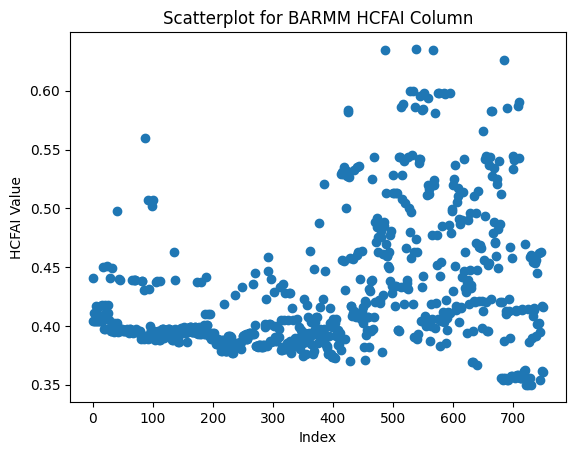

In [53]:
# Scatterplot for the 'HCFAI' column
plt.scatter(x.index, x['HCFAI'])
plt.title('Scatterplot for BARMM HCFAI Column')
plt.xlabel('Index')
plt.ylabel('HCFAI Value')
plt.show()

# Feasibility Factors

In [54]:
# a = a['buildability_landcov'].notna()
a = df[['Road_Presence', 'POI_Presence', 'RHU_Presence', 'buildability_landcov',
       'drought_value', 'rain intensity_value', 'flood_probability_value', 'HCFAI']]

a = a[a['RHU_Presence']==0]
a = a.sort_values(by='HCFAI', ascending=False)
a

,Road_Presence,POI_Presence,RHU_Presence,buildability_landcov,drought_value,rain intensity_value,flood_probability_value,HCFAI
539,1,1,0,1.0,0.639380,1.106916,0.112316,0.635521
487,1,1,0,1.0,0.727157,0.975271,0.109398,0.634995
567,1,1,0,1.0,0.738833,0.959977,0.118986,0.634317
528,1,0,0,1.0,0.647501,1.113930,0.088207,0.599855
534,1,0,0,1.0,0.624971,1.134798,0.108667,0.599413
...,...,...,...,...,...,...,...,...
691,0,0,0,0.0,1.335032,0.747611,0.464469,0.354189
684,0,0,0,0.0,1.350125,0.771746,0.434999,0.353724
692,0,0,0,0.0,1.343102,0.754531,0.459339,0.353665
722,0,0,0,0.0,1.439156,0.767406,0.403463,0.349852


# Maximal Coverage Factors

In [55]:
b = df[['popden_you', 'popden_wom', 'popden_eld', 'popden_chi',
       'popden_w_1', 'popden_all', 'Distance_to_Nearest_RHU_km', 'RHU_Presence', 'HCFAI']]
# b = b[b['buildability_landcov']==1]
b = b.sort_values(by='HCFAI', ascending=False)
# b[b['RHU_Presence']==1]
b

,popden_you,popden_wom,popden_eld,popden_chi,popden_w_1,popden_all,Distance_to_Nearest_RHU_km,RHU_Presence,HCFAI
539,0.393434,1.070501,0.022555,0.321461,0.521806,5.161076,8.237737,0,0.635521
487,0.829292,2.263041,0.165208,0.842835,1.057024,0.927838,1.647829,0,0.634995
567,0.101189,0.236583,0.012827,0.078386,0.118292,0.073577,1.647527,0,0.634317
686,0.348628,1.334747,0.009961,0.303804,0.532903,0.360849,0.000000,1,0.626222
528,0.899503,1.721097,0.446210,0.361218,0.871173,2.309745,7.504187,0,0.599855
...,...,...,...,...,...,...,...,...,...
684,0.365354,1.177451,0.016278,0.291198,0.519091,0.693144,1.647331,0,0.353724
692,0.847945,1.811059,0.108994,0.350582,0.944864,0.440413,5.706339,0,0.353665
731,0.224398,0.499056,0.055923,0.072912,0.276781,0.233144,0.000000,1,0.349852
726,0.224398,0.499056,0.055923,0.072912,0.276781,0.394396,0.981406,0,0.349852


# EDA

In [56]:
c=df['HCFAI'].notna()
c = df[c]
# c = df[['population_youth', 'population_women', 'population_elder60plus', 'population_children_under5',
#        'population_reproductive_women', 'popden_all_total_population', 'Distance_to_Nearest_RHU_km',
#         'Road_Presence', 'POI_Presence', 'RHU_Presence', 'buildability_landcov', 'drought_value', 'rain intensity_value',
#         'flood_probability_value', 'HCFAI']]
# c = c[c['RHU_Presence']==1]
c = c.sort_values(by='HCFAI', ascending=False)
c = c[['population_youth', 'population_women', 'population_elder60plus', 'population_children_under5',
       'population_reproductive_women', 'popden_all_total_population', 'Distance_to_Nearest_RHU_km',
        'Road_Presence', 'POI_Presence', 'RHU_Presence', 'buildability_landcov', 'drought_value', 'rain intensity_value',
        'flood_probability_value', 'HCFAI']]
c.sort_values(by='HCFAI', ascending=False)

KeyError: "['population_youth', 'population_women', 'population_elder60plus', 'population_children_under5', 'population_reproductive_women', 'popden_all_total_population'] not in index"

In [ ]:
# Scatterplot for the 'HCFAI' column
plt.scatter(c.index, c['HCFAI'])
plt.title('Scatterplot for HCFAI Column')
plt.xlabel('Index')
plt.ylabel('HCFAI Value')
plt.show()

# Exporting

In [57]:
# Specify the file path for the CSV file
csv_file_path = '/content/drive/MyDrive/MS thesis/HFCAI/BARMM/barmm_HCFAI_mean.csv'
# Export the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)
print(f'DataFrame exported to CSV file: {csv_file_path}')

DataFrame exported to CSV file: /content/drive/MyDrive/MS thesis/HFCAI/BARMM/barmm_HCFAI_mean.csv
